# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
# Your code here
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

In [2]:
housing_prices_dataset = pd.read_csv("../data/boston_data.csv")

In [3]:
housing_prices_dataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [4]:
housing_prices_dataset.dropna(how="any", inplace=True)

In [5]:
# To remove outliers, I am going to base the development with the 1.5xIQR rule

# Source: https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule

In [6]:
# Before removing outliers
housing_prices_dataset.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


In [7]:
x = pd.DataFrame()

for value in housing_prices_dataset:
    Q1 = housing_prices_dataset[value].quantile(0.25)
    Q3 = housing_prices_dataset[value].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_iqr = (Q3 + (1.5 * IQR))
    lower_iqr = (Q1 - (1.5 * IQR))
    
    value_higher_upperiqr = (housing_prices_dataset[value] > upper_iqr)
    value_lower_loweriqr = (housing_prices_dataset[value] < lower_iqr)
    
    df_filtered = housing_prices_dataset[value_lower_loweriqr | value_higher_upperiqr]
    
    for index in df_filtered.index:
        row = housing_prices_dataset.iloc[index]
        row[value] = np.nan

In [8]:
# After removing outliers
housing_prices_dataset.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,362.000000,355.000000,404.000000,376.0,404.000000,383.000000,404.000000,399.000000,404.000000,404.000000,392.000000,343.000000,402.000000,377.000000
mean,1.529975,3.260563,11.189901,0.0,0.556710,6.260872,68.601733,3.710142,9.836634,411.688119,18.614286,388.311458,12.491493,20.841379
std,2.613454,7.895083,6.814909,0.0,0.117321,0.516646,28.066143,1.963169,8.834741,171.073553,1.947403,11.528793,6.771953,6.449545
min,0.006320,0.000000,0.460000,0.0,0.392000,4.880000,2.900000,1.169100,1.000000,187.000000,13.600000,343.280000,1.730000,5.600000
25%,0.070578,0.000000,5.190000,0.0,0.453000,5.909500,45.800000,2.082850,4.000000,281.000000,17.400000,385.070000,7.125000,16.600000
50%,0.191030,0.000000,9.795000,0.0,0.538000,6.223000,76.600000,3.152300,5.000000,330.000000,19.100000,392.920000,11.235000,20.900000
75%,1.351750,0.000000,18.100000,0.0,0.631000,6.577000,94.150000,5.100400,24.000000,666.000000,20.200000,396.900000,16.702500,24.200000
max,9.966540,30.000000,27.740000,0.0,0.871000,7.691000,100.000000,9.222900,24.000000,711.000000,22.000000,396.900000,30.810000,36.500000


In [9]:
housing_prices_dataset.dropna(how="any", inplace=True)

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

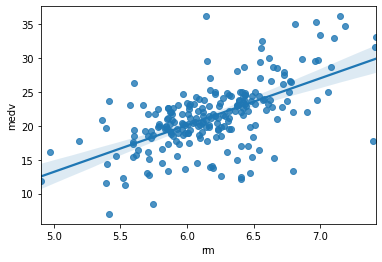

In [10]:
# Your plots here
ax = sns.regplot(x="rm", y="medv", data=housing_prices_dataset)
plt.show()

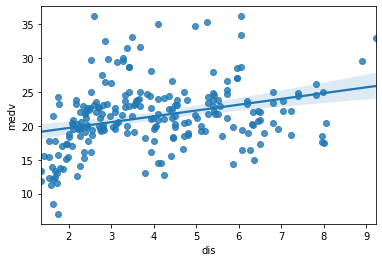

In [11]:
ax = sns.regplot(x="dis", y="medv", data=housing_prices_dataset)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [12]:
# Your response here

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

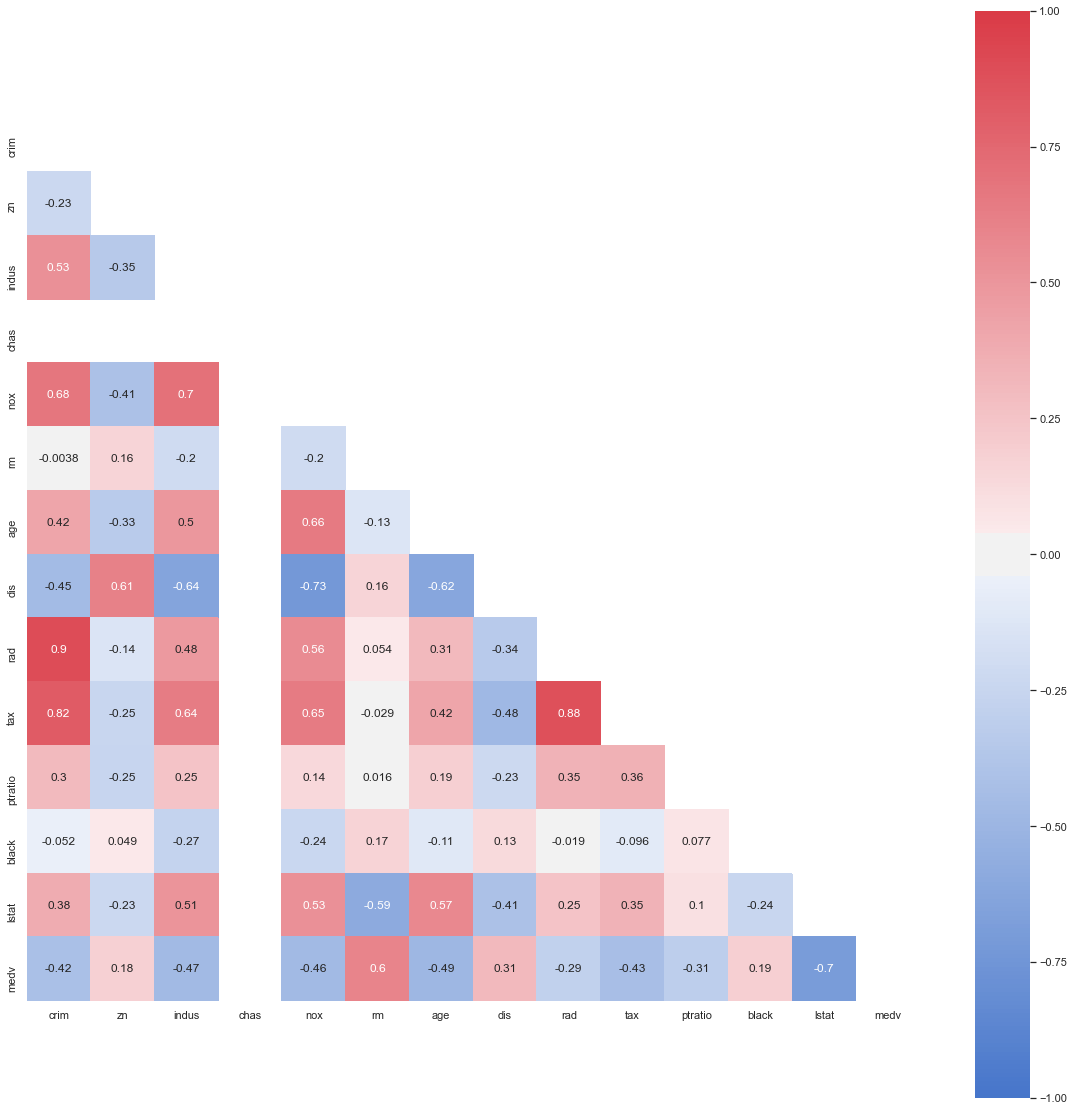

In [13]:
# Reusing function from other labs.

# Your code here
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(housing_prices_dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors

# Plot the heatmap
sns.heatmap(housing_prices_dataset.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)

In [14]:
# Discovered chas is empty. Removing it and visualizing it again. We should have removed at the beginning.

In [15]:
housing_prices_dataset.drop("chas", axis=1, inplace=True)

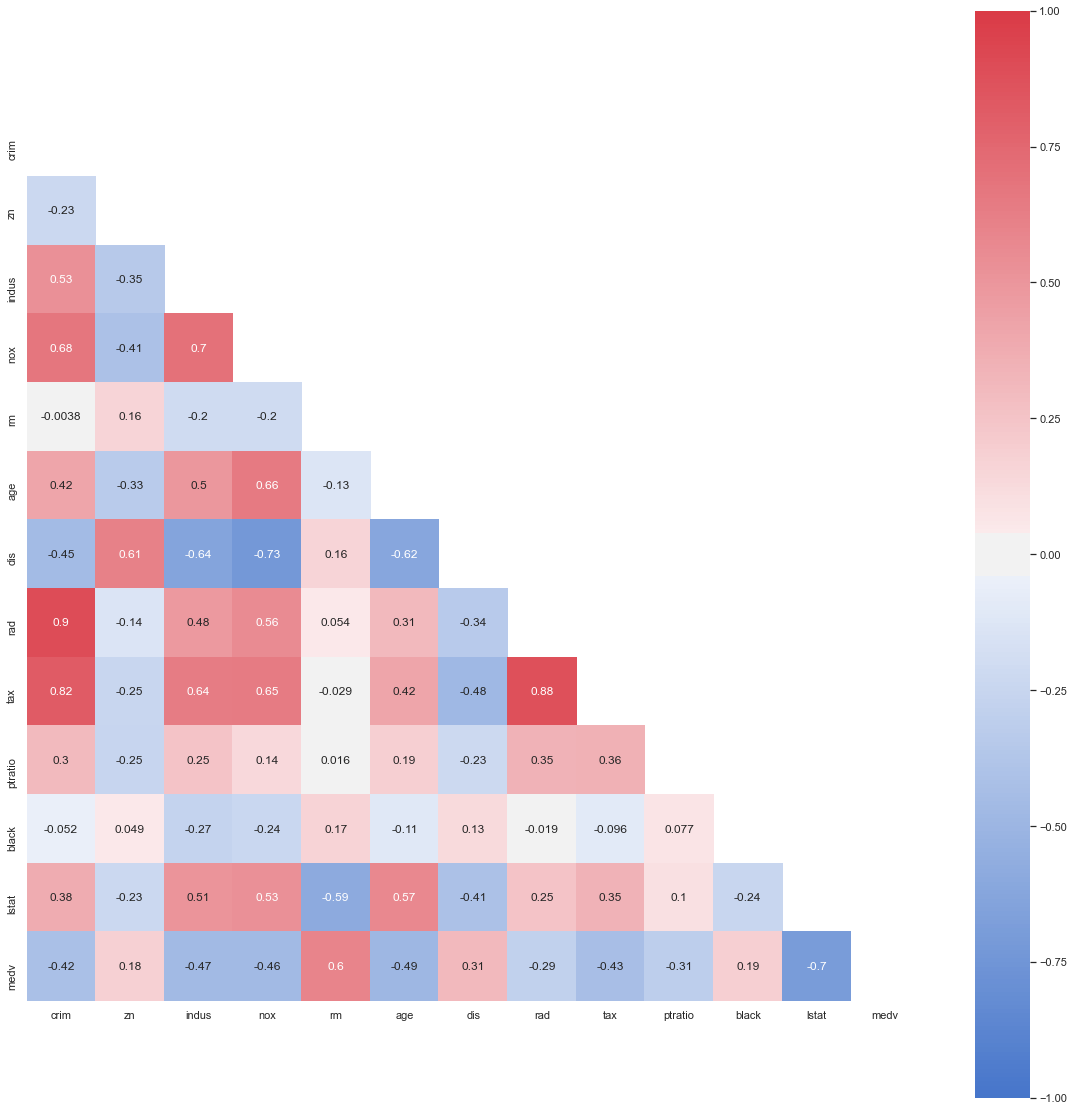

In [16]:
# Your code here
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(housing_prices_dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors

# Plot the heatmap
sns.heatmap(housing_prices_dataset.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)

In [17]:
# Actually we pointed out very well our variables before. Now with this confirmation it makes sense the distance from house to employment centres and average number of rooms affects the median price. 

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [18]:
# Your code here

housing_prices_dataset.medv.describe()

count    228.000000
mean      21.412719
std        4.971316
min        7.000000
25%       18.775000
50%       21.200000
75%       23.825000
max       36.200000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [19]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [20]:
from sklearn.model_selection import train_test_split 

# Target column
y = housing_prices_dataset["medv"]

# Feature columnns
X = housing_prices_dataset.drop(columns="medv")

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

In [21]:
from sklearn.ensemble import RandomForestRegressor

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [22]:
# Five separate RFR here with the given max depths

rfr_model_1 = RandomForestRegressor(max_depth = 2)
rfr_model_2 = RandomForestRegressor(max_depth = 4)
rfr_model_3 = RandomForestRegressor(max_depth = 6)
rfr_model_4 = RandomForestRegressor(max_depth = 8)
rfr_model_5 = RandomForestRegressor(max_depth = 10)

model_array = [rfr_model_1, rfr_model_2, rfr_model_3, rfr_model_4, rfr_model_5]

In [41]:
for model in model_array:
    model.fit(X_train, y_train)

Now, plot the score for each tree on the training set and on the testing set.

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [25]:
# Your response here

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [26]:
# Your response here

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [27]:
# Your response here

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [28]:
# Your response here